### CSCI E-82  Homework 4

### Due by 10/30/2021 at 11:59pm EST to the Canvas dropbox

## This is an individual homework so there should be no collaboration for this homework.


#### Under each problem, we have a place for you to write the answer, or write runnable code that will produce the answer.  Show your work.  Provide insights that are guiding your steps and interpretations of your results.
-----------


## Your Name: Marina Engelhardt

In [ ]:
# ! pip install lifelines
# ! pip install scikit-survival
# ! pip install statsmodels

In [ ]:
# import
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import itertools
import operator
import datetime as dt
from itertools import product
from tqdm import tqdm_notebook

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import OLSInfluence as olsi
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from lifelines import CoxPHFitter # ! pip install lifelines
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis # ! pip install scikit-survival
from lifelines import KaplanMeierFitter
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error,mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats import diagnostic as diag
from sklearn.ensemble import RandomForestClassifier
from statsmodels.graphics.gofplots import qqplot
from seaborn import regplot
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler


from pprint import PrettyPrinter
pprint = PrettyPrinter().pprint
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

## Problem 1 Survival Analysis (25 points)

This problem uses the survival_unemployment.csv data file provided.
The dataset is exploring unemployment for 3300 affected individuals.  An event of 1 indicates that a person found a job after "weeks" search.  The remaining variables characterize the person and previous salary.

### Problem 1a (8 points)

Create a Kaplan-Meier plot of the raw data (no other variables).  Use this to answer what is the median time it takes for individuals to find a job.

In [ ]:
# load data
unempl_data = pd.read_csv('survival_unemployment.csv')
print('Data set dimentions:', unempl_data.shape)
print('Missing values: ',unempl_data.isnull().values.sum()) # check missing values
unempl_data.head()

Data set dimentions: (3300, 8)
Missing values:  0


,weeks,event,age,logsalary,married,isfemale,hasChildren,caucasian
0,5,1,41,6.843981,1,0,1,1
1,13,1,30,5.429075,1,0,1,1
2,20,1,36,6.862836,0,0,0,1
3,3,1,26,5.843073,1,0,1,0
4,8,0,22,6.292216,0,0,0,1


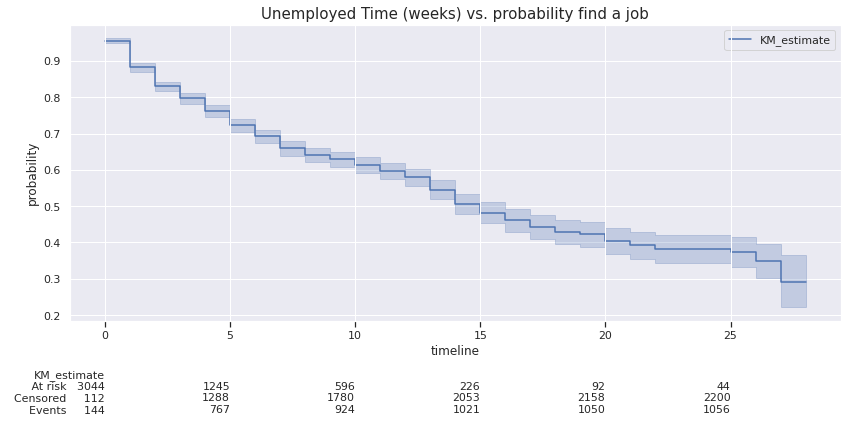

In [ ]:
# Kaplan-Meier plot (source: Section 7 - Survival Analysis)
kmf = KaplanMeierFitter()
T = unempl_data['weeks']
C = unempl_data['event']
kmf.fit(T,C);

fig, ax = plt.subplots(figsize=(12,6))
kmf.plot(at_risk_counts=True)
plt.title('Unemployed Time (weeks) vs. probability find a job', fontsize=15)
ax.set_ylabel('probability')
ax.grid(b=True)

From the plot, we see that probability at time zero is almost 1.0, and it appears that not 100% of the participants were unemloyed at time zero. The column "event" indicates that some of the partisipants were employed at week 0. We see that 3,044 out of 3,300 participants are "at risk" (112 were censored and 144 found a job). We will assume that all were unemployed at the start, and censoring and event occured right after the start.

The median time it takes for individual to find a job is the point in time in which on average 50% of individuals have found a job.   
From plot observation we see that the median is 15 weeks of search.  

In [ ]:
# to check if our observed estimation is correct
kmf.median_survival_time_

15.0

### Problem 1b (4 points)

Some say that married folks have an easier time finding work.  Create a Kaplan-Meier plot and interpret the difference in duration (which group and by how many weeks) for the first 25% that find work.

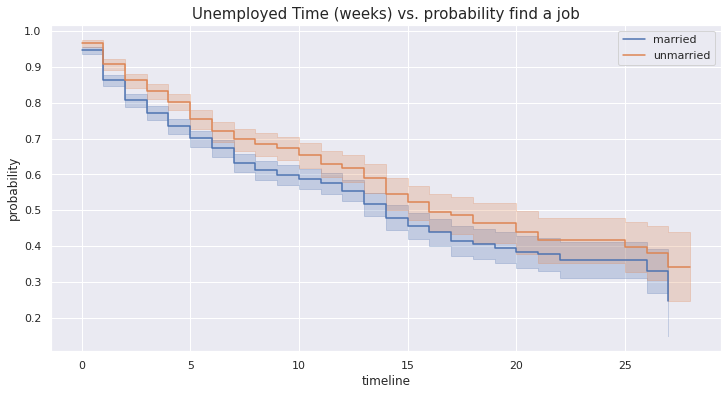

In [ ]:
#Breaking it down by Married/Unmarried (source: Section 7 - Survival Analysis)
fig, ax = plt.subplots(figsize=(12,6))

labels = ['married','unmarried'] # maried=1, unmarried=0
tick_spacing = 0.1

plt.title('Unemployed Time (weeks) vs. probability find a job', fontsize=15)
ax.set_ylabel('probability')
for r in unempl_data['married'].unique():
    ix = unempl_data[unempl_data['married']==r].index
    kmf.fit(T[ix], C[ix], label=labels[r-1])
    kmf.plot(ax=ax)

ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.grid(b=True)

As we assumed that no one was employed at the start, our checkpoint roughly at 75% as it's 25% from the starting point.   
Difference in duration for the first 25% that find a job for each group:
married - about 4 weeks, unmarried - about 6 weeks.

### Problem 1c (8 points)

Iterate on the Cox Proportional Hazards Model to identify the set of features (age, logsalary, married, isfemale, hasChildren, caucasian).


In [ ]:
cph = CoxPHFitter()
cph.fit(unempl_data, duration_col='weeks', event_col='event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 3300 total observations, 2238 right-censored observations>
             duration col = 'weeks'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 3300
number of events observed = 1062
   partial log-likelihood = -7793.61
         time fit was run = 2021-11-01 21:03:04 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age          -0.02       0.98       0.00            -0.03            -0.01                 0.97                 0.99
logsalary     0.30       1.35       0.06             0.18             0.42                 1.20                 1.53
married       0.28       1.32       0.07             0.13             0.42                 1.14                 1.53
isfemale      0.11       1.11       0.07            -0.03             0.24                 0.98                 1.27
hasChildren  -0.08       0.93       0.07            -0.21             0.06                 0.81                 1.06
caucasian     0.58       1.79       0.11             0.37             0.80                 1.44                 2.22

                z      p   -log2(p)
covariate                          
age         -6.17 <0.005      30.46
logsalary    4.82 <0.005      19.41
married      3.76 <0.005      12.54
isfemale     1.59   0.11       3.16
hasChildren -1.10   0.27       1.89
caucasian    5.32 <0.005      23.20
---
Concordance = 0.59
Partial AIC = 15599.21
log-likelihood ratio test = 107.37 on 6 df
-log2(p) of ll-ratio test = 66.91

We see that "isfemale" and "hasChildren" have very large p-values (>0.05), that inicates their statistical insignificance. We will remove feature with the largest p-value.

In [ ]:
features = ['weeks', 'event', 'age', 'logsalary', 'isfemale', 'married',  'caucasian'] #  'hasChildren' removed
cph2 = CoxPHFitter()
cph2.fit(unempl_data[features], duration_col='weeks', event_col='event')
cph2.params_

covariate
age         -0.019090
logsalary    0.301381
isfemale     0.106014
married      0.241920
caucasian    0.592136
Name: coef, dtype: float64

We see that coeficients got ajusted, that means the effect of the change in each feature will have a slightly different affect on the outcome.

In [ ]:
features = ['weeks', 'event', 'age', 'logsalary',  'married',  'caucasian'] #  'isfemale' removed
cph3 = CoxPHFitter()
cph3.fit(unempl_data[features], duration_col='weeks', event_col='event')
cph3.print_summary()

<lifelines.CoxPHFitter: fitted with 3300 total observations, 2238 right-censored observations>
             duration col = 'weeks'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 3300
number of events observed = 1062
   partial log-likelihood = -7795.42
         time fit was run = 2021-11-01 21:16:26 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age        -0.02       0.98       0.00            -0.02            -0.01                 0.98                 0.99
logsalary   0.27       1.31       0.06             0.16             0.39                 1.17                 1.48
married     0.24       1.27       0.07             0.11             0.37                 1.11                 1.45
caucasian   0.59       1.81       0.11             0.38             0.81                 1.46                 2.24

              z      p   -log2(p)
covariate                        
age       -5.96 <0.005      28.52
logsalary  4.58 <0.005      17.70
married    3.59 <0.005      11.58
caucasian  5.44 <0.005      24.14
---
Concordance = 0.59
Partial AIC = 15598.84
log-likelihood ratio test = 103.74 on 4 df
-log2(p) of ll-ratio test = 69.11

We see that all features are statistically significant for the model.   
Fr example, "age" has a coefficient of -0.02. it the least significant feature. A one unit (1 year) increase in this factor means the the baseline hazard will decrease by a factor of exp(-0.2)=0.98 - about a 2% decrease. Cox proportional hazard model, a higher hazard means more at risk of the event occurring.

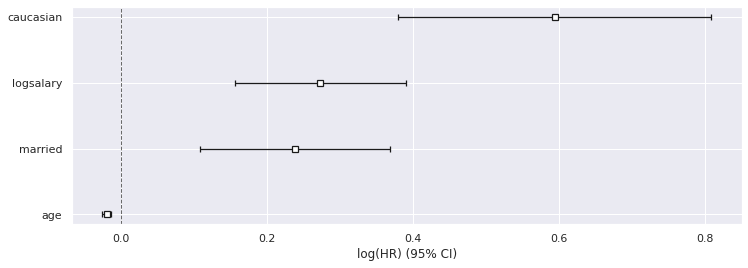

In [ ]:
fig, ax = plt.subplots(figsize=(12,4));
cph.plot(ax=ax)
plt.show()

### Problem 1d (5 points)  

Examination of the 1c results (text not code)

#### Which feature has the most impact on the predicted duration?

The most significant feature is "caucasian" factor (whether the subject is caucasian or not). The values in the "caucasian" are binary: 0 or 1. The value of the coefficient associated with "caucasian", exp(0.59), is the value of ratio of hazards associated with being "caucasian", that is:  
$$
exp(0.59)= \frac{hazard\ of\ caucasian\ subjects\ at\ time\ t}{hazard\ of\ not caucasian\ subjects\ at\ time\ t}$$  
that is exp(0.59) = 1.8 - or about the baseline hazard will increase by about 80%, if partisipant is caucasian.

#### What is the coefficient of this feature?

coeficient = 0.59

In [ ]:
cph3.params_

covariate
age         -0.018735
logsalary    0.273023
married      0.238326
caucasian    0.593780
Name: coef, dtype: float64

#### How much does this feature change the predicted duration of unemployment?

by about 80% (exp(0.59)=1.8) the duartion to fins a job (from the base hazard) will be decreased if a person is identified as caucasian.   
A higher hazard means more at risk of the event occurring.

#### Does it increase or decrease the predicted duration?

It has higher risk of event (employment) to be occure, which decrese the duration of unemployment.

#### What is the concordance of your model?  Is it any good?

Concordance index or c-index is a metric to evaluate the predictions made by an algorithm, on a scale from 0 to 1, where 1 is a perfect prediction.
The Cox Proportional Hazards model has concodance = 0.59. It's not a high value, doesn't look like it a really good model.

## Problem 2 Time Series Modeling (25 points)

Use the data timeSeries4.csv for this problem. The data are monthly reports of production.

### Problem 2a (5 points)
Plot the data and perform an exploratory analysis on the raw time series file. Comment on any trends, outliers, seasonality, whether it's stationary, etc.  You are free to make limited appropriate corrections to the data for the purpose of ensuring a good model.

In [ ]:
xt = pd.read_csv('timeSeries4.csv',  names=['value'])
print('Data set dimentions:', xt.shape)
print('Missing values: ',xt.isnull().values.sum()) # check missing values
xt.head()

Data set dimentions: (148, 1)
Missing values:  0


,value
0,21.684748
1,21.622112
2,19.583297
3,23.290602
4,21.729621


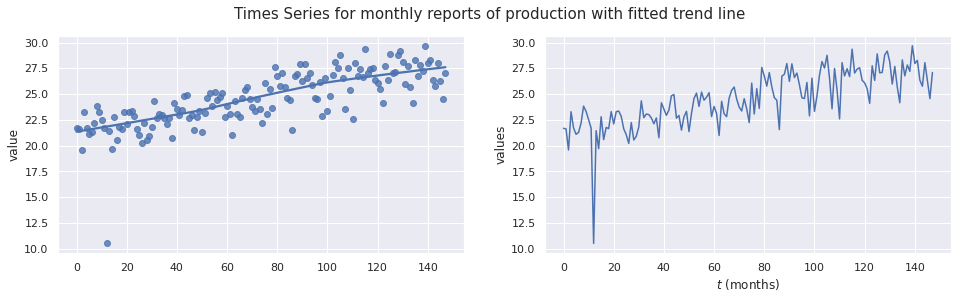

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(16,4))
fig.suptitle('Times Series for monthly reports of production with fitted trend line', fontsize=15)
regplot(xt.index, xt['value'], lowess=True, ax=ax1)
plt.plot(xt.index,xt.values)
plt.xlabel("$t$ (months)")
plt.ylabel("values")
plt.show()

From the time series plot we can conclude that:  
(1) Time series appear to be not stationary. We see that mean and variance are not constant and increasing over time (months).  
(2) We see that we have a trend that appears to be a linear trend.  
(3) At around 16th month we have an outlier  
(4) In addition, at appears that we have to account for seasonality as well.  

We will use `seasonal_decompose` to look at the details to support our initial  observations. For that, we will need to convert index (months) into a datetime format, starting from some random date (for example, Jan-01-2000).

In [ ]:
ts = xt.copy()
ts['date'] = pd.date_range('2000-01-01', freq='MS', periods=148) # 148 months starting from 01/01/2000
ts = ts.set_index('date')
ts.head()

,value
date,
2000-01-01,21.684748
2000-02-01,21.622112
2000-03-01,19.583297
2000-04-01,23.290602
2000-05-01,21.729621


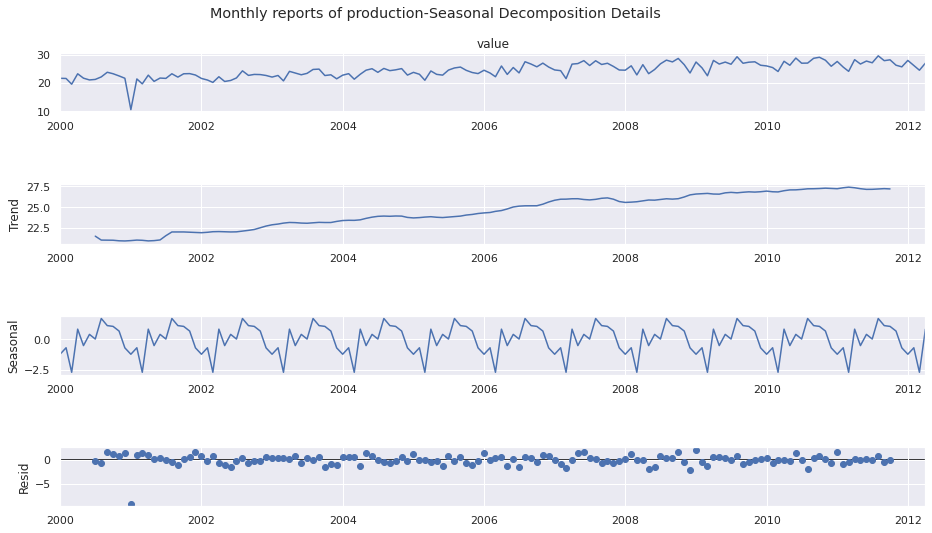

In [ ]:
decompose_result = seasonal_decompose(ts.value, model='additive')
fig = decompose_result.plot()
fig.suptitle('Monthly reports of production-Seasonal Decomposition Details')
fig.set_size_inches(15, 8)

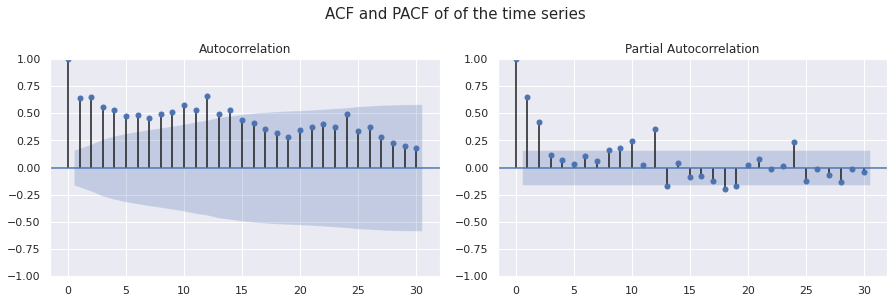

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(15,4))
fig.suptitle('ACF and PACF of of the time series',y=1.06,size=15)
plt.subplots_adjust(wspace = 0.15)
plot_acf(xt, ax=ax[0], lags=30)
plot_pacf(xt, ax=ax[1], lags=30)
plt.show()

`seasonal_decompose` plots confirmed our initial observations. We have a linear trend and yearly seasonality in out time series. Additionally, ACF plot support that we have a trend.  As it shows significant correlation for all lags that smoothly decays.

To have a good model, we have to remove the trend and make our time series stationary. We can achieve that by applying differencing.

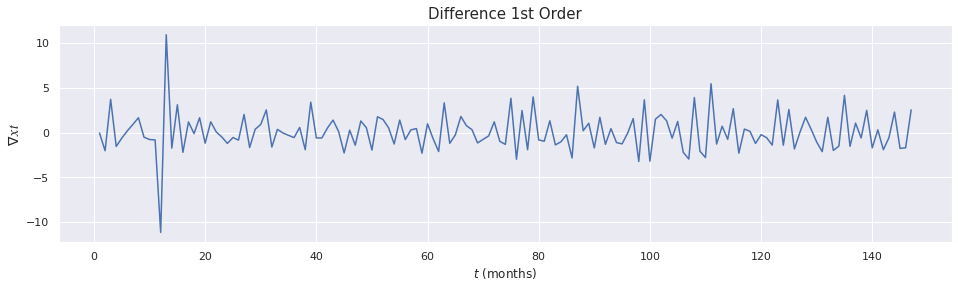

In [ ]:
# Difference 1st Order
plt.figure(figsize=(16,4))
plt.plot(xt.diff())
plt.title('Difference 1st Order', fontsize=15)
plt.ylabel("$∇𝑥𝑡$ ",fontsize=14)
plt.xlabel("$t$ (months)")
plt.show()

It appears that taking the difference of 1st order helped to remove the trend. Now mean seems to be centered around zero, and variance appear to be somewhat constant. However, we still have an issue with the outlier.

Number of missing values in ∇𝑥𝑡 before dropping NaN:  1


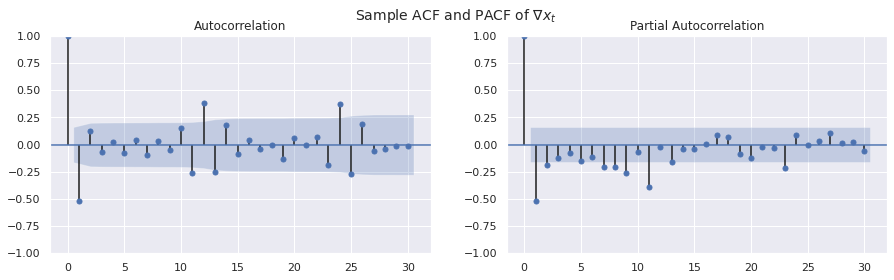

In [ ]:
# drop 1 row with NaN value caused by the difference
xt_diff1 = xt.diff()
print('Number of missing values in ∇𝑥𝑡 before dropping NaN: ',xt_diff1.isnull().values.sum())
xt_diff1 = xt_diff1.dropna()

# plot ACF and PACF of 1st order difference
fig, axes = plt.subplots(1,2,figsize=(15,4))
fig.suptitle('Sample ACF and PACF of ∇$x_t$',size=14)
plot_acf(xt_diff1, lags=30, ax=axes[0])
plot_pacf(xt_diff1, lags=30, method='ywm', ax=axes[1])
plt.show()

ACF plot suggests that we don't have a trend, but it appears that we have a seasinality with factor 12 (yearly). Thus in our base modeline model we will start from removing the trend by adding the difference.

### Problem 2b (20 points)
Model the data as discussed in lecture and section.  You will likely try a number of different models until something "works".  Do include what you tried with a 1-line explanation for what's wrong and what you're trying next unless you fully automate the search (which is more difficult). Apply the appropriate diagnostics

In [ ]:
# Create a group of plots for diagnostics
# function is taken from the section 8
def visualize_diagnostics(data):
    fig = plt.figure(figsize=(16,10))
    plt.subplots_adjust(wspace = 0.3,hspace = 0.3,bottom = 0)
    layout = (3, 2)

    data_ax = plt.subplot2grid(layout, (0, 0), colspan=1)
    hist_ax = plt.subplot2grid(layout, (0, 1), colspan=1)
    acf_ax = plt.subplot2grid(layout, (1, 0), colspan=1)
    pacf_ax = plt.subplot2grid(layout, (1, 1), colspan=1)
    qq_ax = plt.subplot2grid(layout, (2, 0), colspan=1)
    lbox_ax = plt.subplot2grid(layout, (2, 1), colspan=1)

    lbox_df = diag.acorr_ljungbox(data, lags=None,return_df=True)

    data.plot(ax=data_ax, title="Residuals")
    data.hist(ax=hist_ax)
    acf = plot_acf(data, ax=acf_ax)
    pacf = plot_pacf(data, ax=pacf_ax)
    qqplot(data, ax=qq_ax, line='q')
    lbox_ax.plot(lbox_df.lb_pvalue)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  148
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -325.881
Date:                Mon, 01 Nov 2021   AIC                            653.762
Time:                        18:21:04   BIC                            656.752
Sample:                    01-01-2000   HQIC                           654.977
                         - 04-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.9327      0.276     17.886      0.000       4.392       5.473
Ljung-Box (L1) (Q):                  39.82   Jarque-Bera (JB):               276.02
Prob(Q):                              0.00   Pr

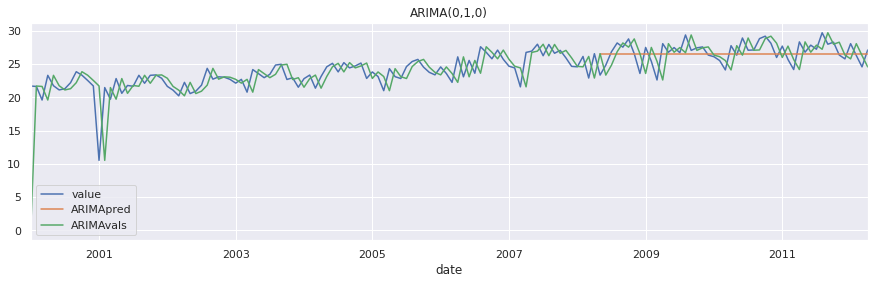

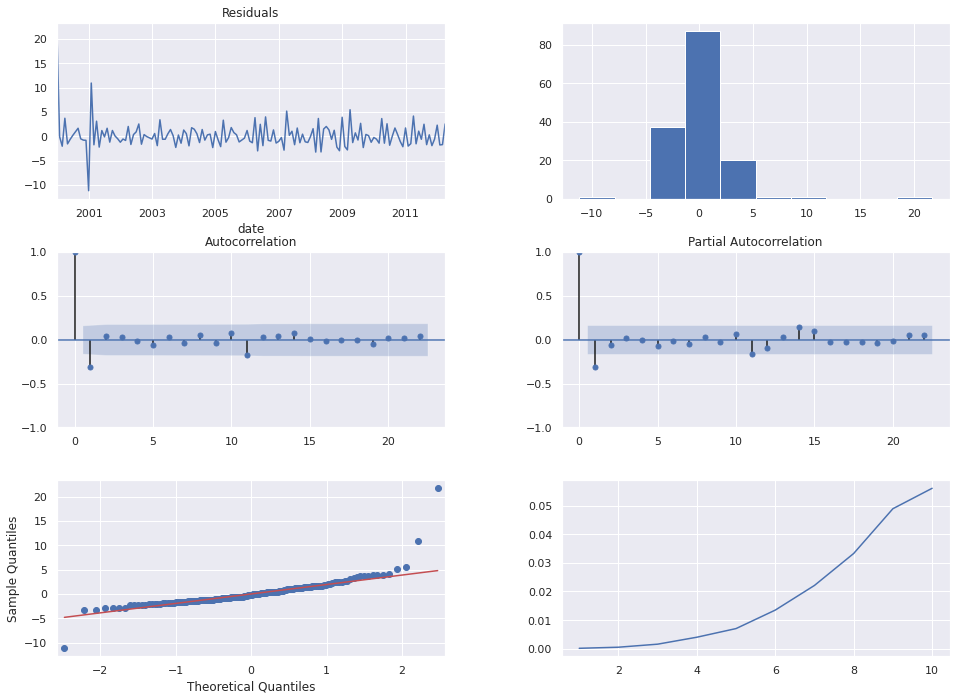

In [ ]:
# (1)
# we observed that difference helps remove the trend,
# we will fit a simple ARIMA(0,1,0) model with a difference d=1 as a baseline
arima1 = ARIMA(ts['value'], order=(0,1,0))
model1 = arima1.fit()
print(model1.summary())

ts['ARIMAvals'] = model1.fittedvalues
ts['ARIMApred'] = model1.predict(start=100, end=147, dynamic=True) #typ = 'levels'typ='levels'
ts[['value','ARIMApred','ARIMAvals']].plot(figsize=(15,4), title='ARIMA(0,1,0)')
visualize_diagnostics(model1.resid)

Differencing appears to help making time series stationary. The mean appears to be centered around zero, and the variance somewhat doesn't depend on time. Predictions seems to be capturing trend but not seasonality.   
Additionally, histogram and QQ-plot suggest that we don't have a normal distrubution. ACF and PACF plots show some correlation at lags=1 and 11, that supprts seasonality. ACF suggests to try MA order 1, and  PACF suggest to try AR order 1. We will try to add AR part first.

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  148
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -303.160
Date:                Mon, 01 Nov 2021   AIC                            610.321
Time:                        18:21:58   BIC                            616.302
Sample:                    01-01-2000   HQIC                           612.751
                         - 04-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5159      0.045    -11.576      0.000      -0.603      -0.429
sigma2         3.6134      0.187     19.361      0.000       3.248       3.979
Ljung-Box (L1) (Q):                   1.52   Jarque-

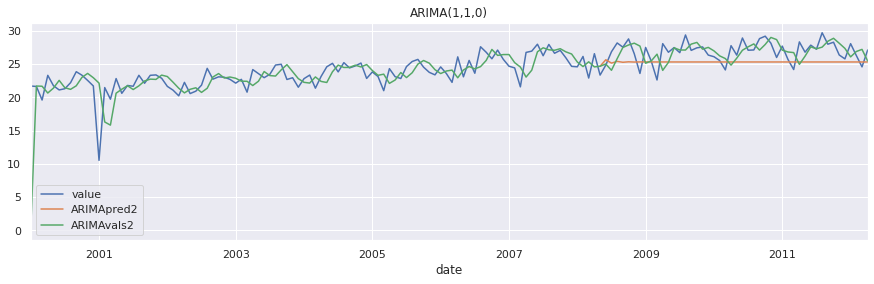

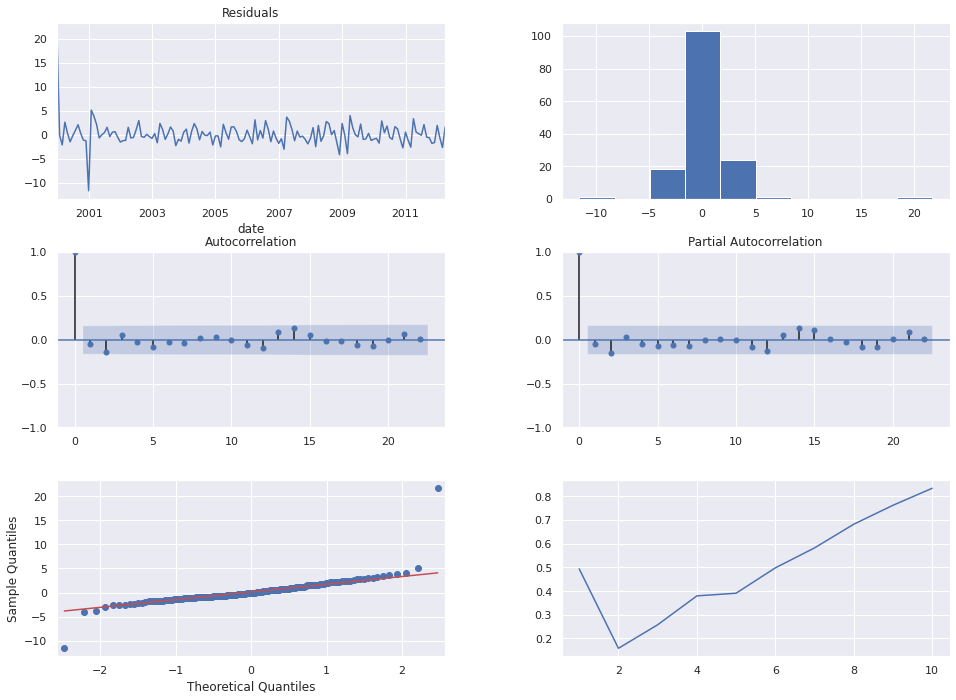

In [ ]:
# (2)
# ARIMA(1,1,0)
arima2 = ARIMA(ts['value'], order=(1,1,0))
model2 = arima2.fit()
print(model2.summary())

ts['ARIMAvals2'] = model2.fittedvalues
ts['ARIMApred2'] = model2.predict(start=100, end=147, dynamic=True)

ts[['value','ARIMApred2','ARIMAvals2']].plot(figsize=(15,4), title='ARIMA(1,1,0)')
visualize_diagnostics(model2.resid)

We got a better fit for ARIMA(1,1,0).   
ACF and PACF plats show no correlation amongst residuals (only at lag=0, which is expected), they resemble a white noise.  
Histogram and QQ-plot show somewhat normal ditribution which is disrupted by values (10 and 20), that require additional analysis.  
However, this model is not a good fit as the requiremets of the "acorr_ljungbox" plot are not sutified. We will try higher order of AR and add MA.

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  148
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -292.727
Date:                Mon, 01 Nov 2021   AIC                            591.454
Time:                        18:23:06   BIC                            600.425
Sample:                    01-01-2000   HQIC                           595.099
                         - 04-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1321      0.093      1.424      0.154      -0.050       0.314
ma.L1         -0.8844      0.060    -14.800      0.000      -1.001      -0.767
sigma2         3.1143      0.175     17.751      0.0

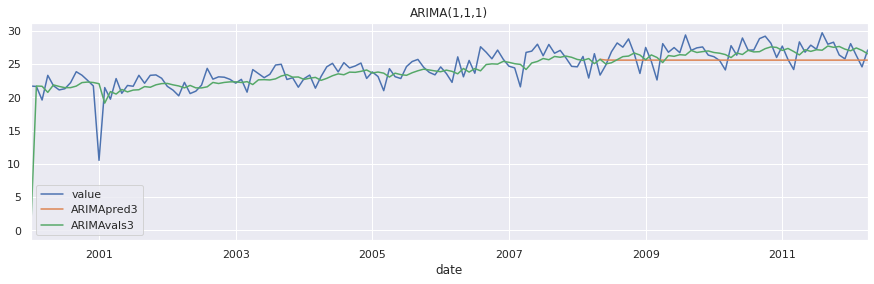

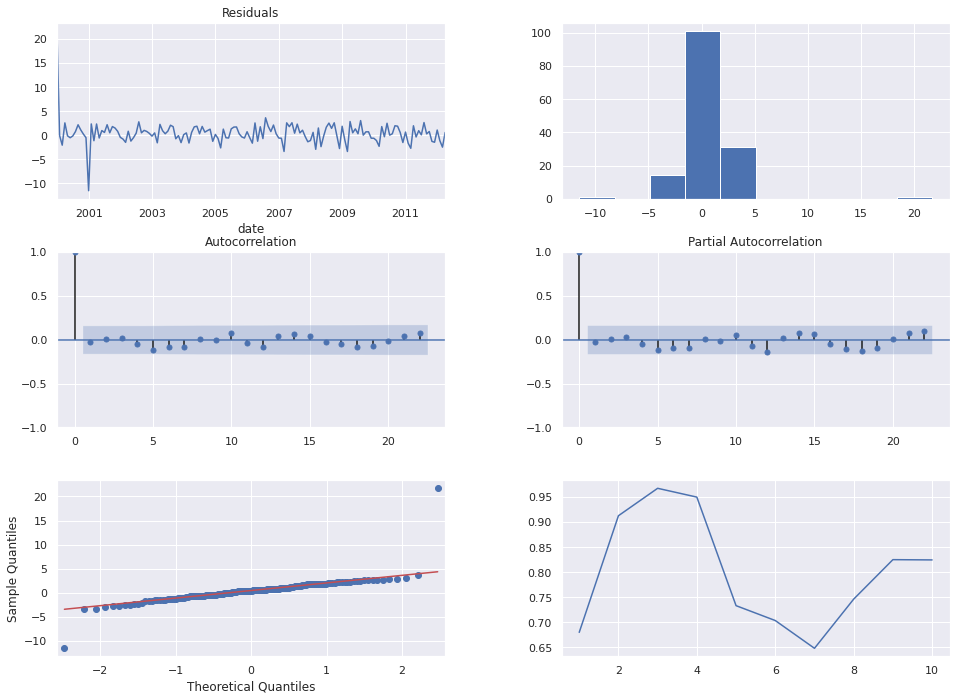

In [ ]:
# (3)
# ARIMA(1,1,1)
arima3 = ARIMA(ts['value'], order=(1,1,1))
model3 = arima3.fit()
print(model3.summary())

ts['ARIMAvals3'] = model3.fittedvalues
ts['ARIMApred3'] = model3.predict(start=100, end=147, dynamic=True)

ts[['value','ARIMApred3','ARIMAvals3']].plot(figsize=(15,4), title='ARIMA(1,1,1)')
visualize_diagnostics(model3.resid)

ACF, PACF, and "acorr_ljungbox" plot are satisfied. We don't see correlation. We will check outliers and will see if dropping them will improve the ditribution.

The lowest value seems to be insignificant for the time series, we will remove it. The highest value appears to be related to seasonality.

In [ ]:
# drop outlier with min value
print(ts['value'].min())
print(ts['value'].idxmin())
ts = ts.drop(pd.Timestamp('2001-01-01 00:00:00'))

10.52134459
2001-01-01 00:00:00


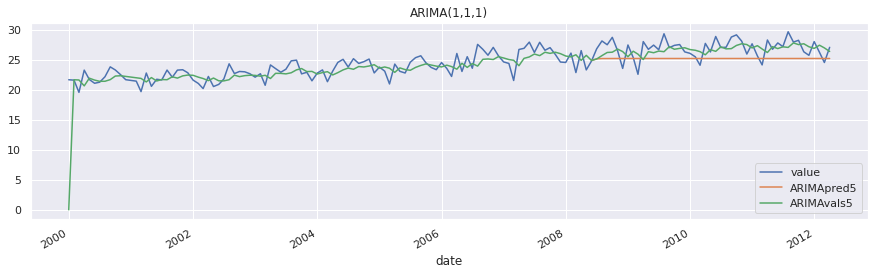

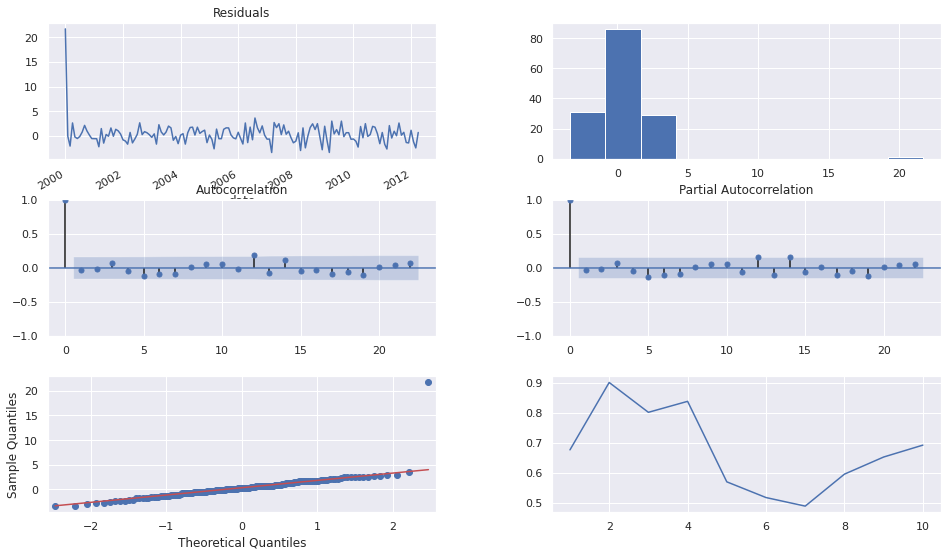

In [ ]:
# (4)
# ARIMA(1,1,1) with removed outlier
arima5 = ARIMA(ts.value, order=(1,1,1))
model5 = arima5.fit()

ts['ARIMAvals5'] = model5.fittedvalues
ts['ARIMApred5'] = model5.predict(start=100, end=146, dynamic=True)
ts[['value','ARIMApred5','ARIMAvals5']].plot(figsize=(15,4), title='ARIMA(1,1,1)')
visualize_diagnostics(model5.resid)

QQ-plot loks a bit better, now we will account for seasonality.

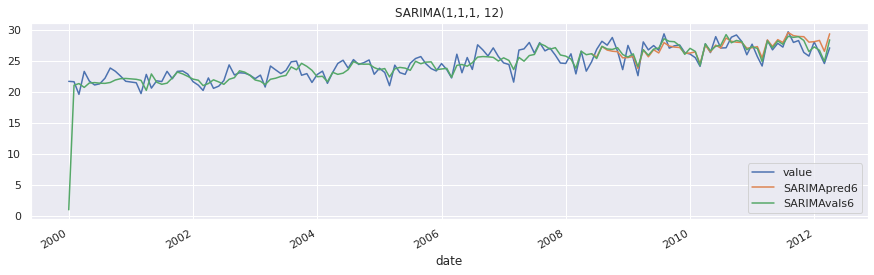

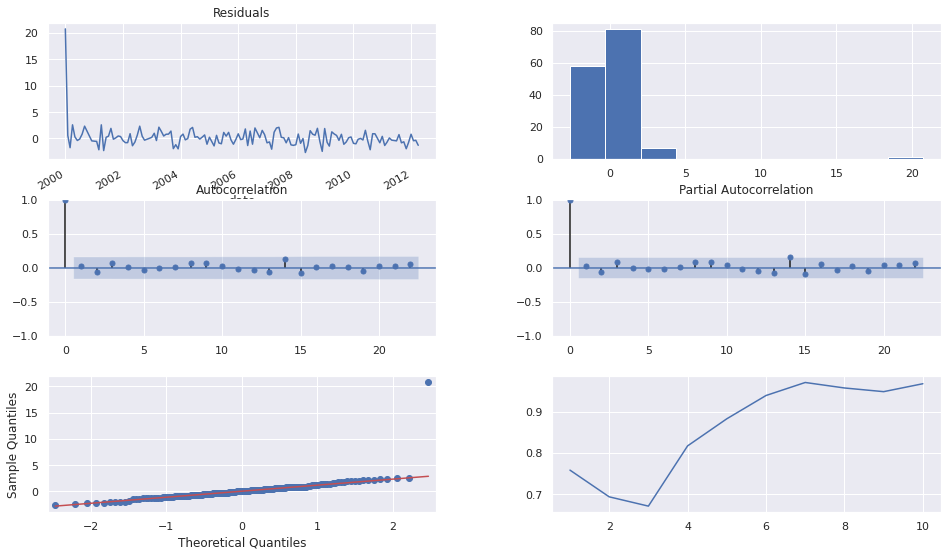

In [ ]:
# (5)
# SARIMA with seasonal order=12 & trend
sarima6 = SARIMAX(ts['value'],trend='t', order=(1,0,1), seasonal_order=(1,0,1,12)) # account for trend + seasonality
model6 = sarima6.fit()

ts['SARIMAvals6'] = model6.fittedvalues
ts['SARIMApred6'] = model6.predict(start=100, end=146, dynamic=True)
ts[['value','SARIMApred6','SARIMAvals6']].plot(figsize=(15,4), title='SARIMA(1,1,1, 12)')
visualize_diagnostics(model6.resid)

We see that predicted values are now able to pick up the seasonality, but the normality is not satisfied. We will try to increase P and Q order.

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  147
Model:             SARIMAX(0, 0, 4)x(4, 0, 4, 12)   Log Likelihood                -243.990
Date:                            Tue, 02 Nov 2021   AIC                            515.980
Time:                                    00:18:54   BIC                            557.846
Sample:                                         0   HQIC                           532.991
                                            - 147                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0423      0.003     12.825      0.000       0.036       0.049
ma.L1          0.1773      0.007   

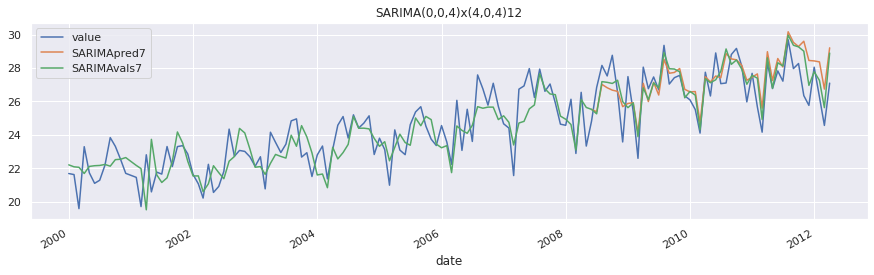

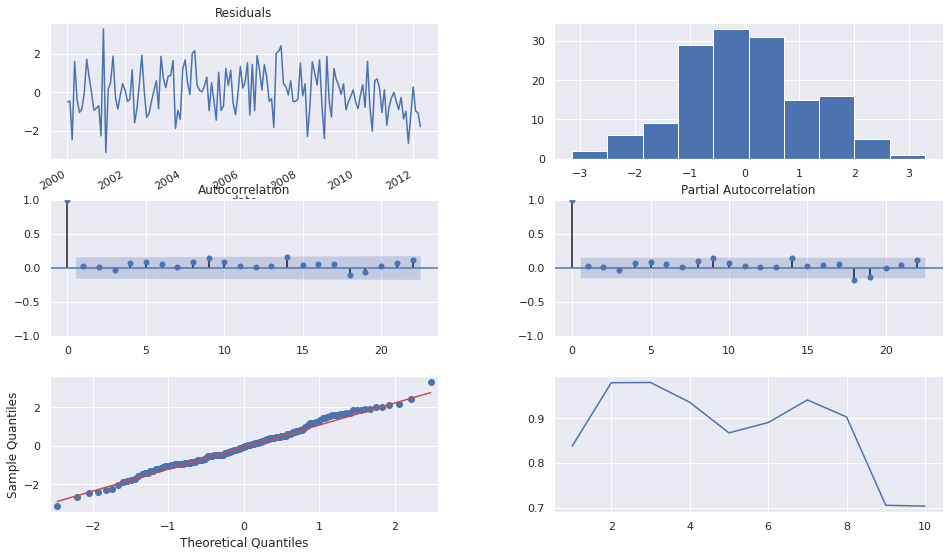

In [ ]:
# (6) We were increasing P and Q order gradually from 1 to 4 until observed normality
sarima7 = SARIMAX(ts['value'],trend='t', order=(0,0,4), seasonal_order=(4, 0, 4, 12))
model7 = sarima7.fit()
print(model7.summary())

ts['SARIMAvals7'] = model7.fittedvalues
ts['SARIMApred7'] = model7.predict(start=100, end=146, dynamic=True)
ts[['value','SARIMApred7','SARIMAvals7']].plot(figsize=(15,4), title='SARIMA(0,0,4)x(4,0,4)12')
visualize_diagnostics(model7.resid)

SARIMA(0,0,4)x(4,0,4)12 model satisfies requirements of independent and normally distributed residuals. Now we can try to optimize the model.

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  147
Model:             SARIMAX(0, 0, 5)x(5, 0, 5, 12)   Log Likelihood                -236.720
Date:                            Mon, 01 Nov 2021   AIC                            507.440
Time:                                    18:30:34   BIC                            558.278
Sample:                                         0   HQIC                           528.096
                                            - 147                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0500      0.006      8.302      0.000       0.038       0.062
ma.L1          0.1877      0.047   

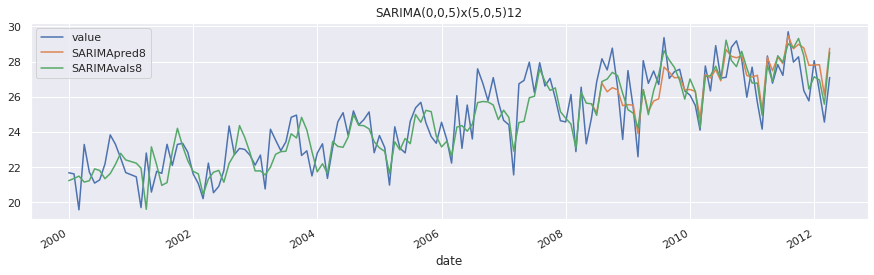

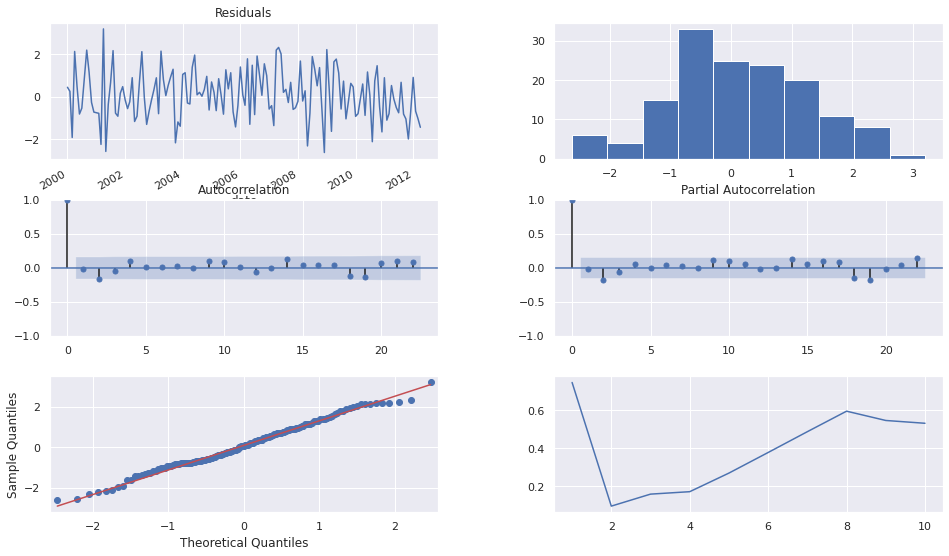

In [ ]:
# (7) Tune model to reduce AIC
sarima8 = SARIMAX(ts['value'],trend='t', order=(0,0,5), seasonal_order=(5, 0, 5, 12))
model8 = sarima8.fit()
print(model8.summary())

ts['SARIMAvals8'] = model8.fittedvalues
ts['SARIMApred8'] = model8.predict(start=100, end=146, dynamic=True)
ts[['value','SARIMApred8','SARIMAvals8']].plot(figsize=(15,4), title='SARIMA(0,0,5)x(5,0,5)12')
visualize_diagnostics(model8.resid)

We tried to increase p/q and P/Q but it seems that further increasing of order doesn't not improve efficiency or vialate idependence and normality. Perhaps, another model or data transformation is needed here to optimize.

## Problem 3 (15 points)

### Problem 3a (4 points)

For the same data (timeSeries4.csv), fit a linear regression model.  It is not necessary to perform the full diagnostics (QQ-plot, verify the residuals are normal, etc.). However, you should be able to fit a simple model to this data.

In [ ]:
lr = sm.OLS(xt.index, sm.add_constant(xt.value)).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     211.1
Date:                Tue, 02 Nov 2021   Prob (F-statistic):           3.74e-30
Time:                        00:27:48   Log-Likelihood:                -699.51
No. Observations:                 148   AIC:                             1403.
Df Residuals:                     146   BIC:                             1409.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -231.7568     21.130    -10.968      0.0

R^2 =0.59, it's not a strong model as only 59% of the data can be explained by this model. Let's check statistics plots and check stationarity.

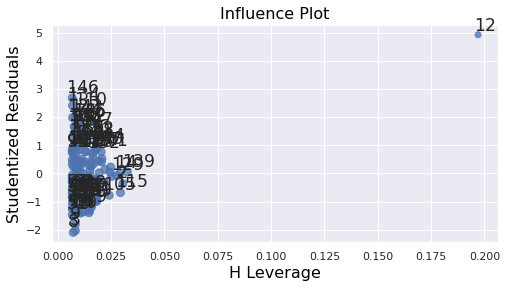

In [ ]:
# check for outliers
fig, ax = plt.subplots(figsize=(8,4))
fig3 = sm.graphics.influence_plot(lr,criterion="cooks", alpha = 0.5, size=6, ax=ax)
plt.show()

General rule of thumb is the points above 3 should not be significant and can be dropped. We will drop values at 12th month.

In [ ]:
# drop outlier at
print(xt.index[12])
xt = xt.drop(12)

12


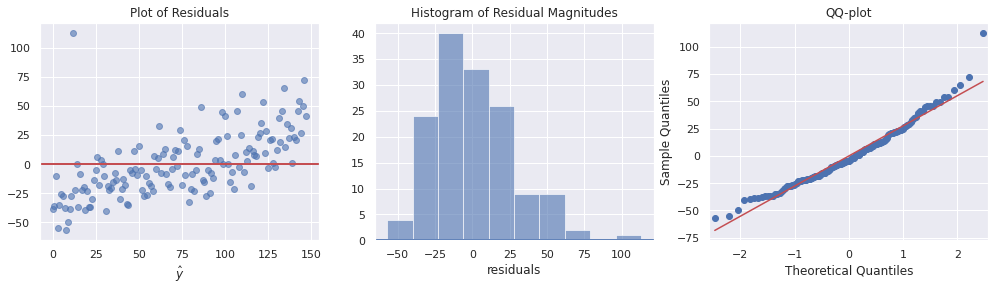

In [ ]:
# satistics plots
fig, axes = plt.subplots(1,3,figsize=(17,4))
axes[0].set_title('Plot of Residuals')
axes[0].scatter(lr.resid.index, lr.resid.values, alpha=0.6)
axes[0].axhline(0, c='r', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')

axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(lr.resid, alpha=0.6)
axes[1].axhline(0, c='b', lw=2)
axes[1].set_xlabel(r'residuals')

axes[2].set_title('QQ-plot')
sm.qqplot(lr.resid, line='r', ax=axes[2])
plt.show()

Plot of statistics indicates that the distribution is skewed that might be caused bythe seasonality and trend.

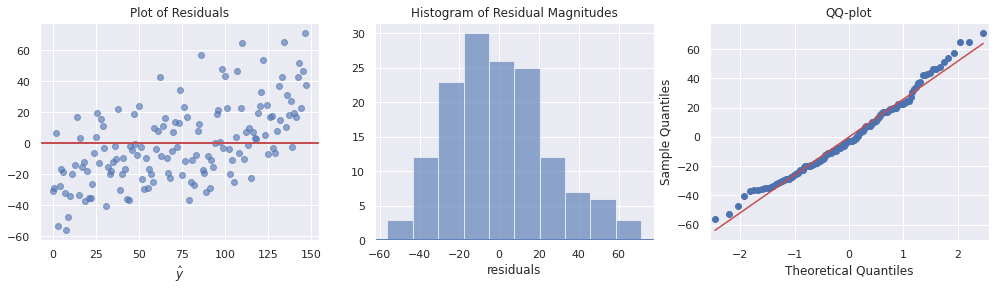

In [ ]:
# we will take the log of the value to make the distribution normal
xt['log_value'] = np.float64(np.log(xt['value']))
lr2 = sm.OLS(xt.index, sm.add_constant(xt.log_value)).fit()

# residual plots
fig, axes = plt.subplots(1,3,figsize=(17,4))
axes[0].set_title('Plot of Residuals')
axes[0].scatter(lr2.resid.index, lr2.resid.values, alpha=0.6)
axes[0].axhline(0, c='r', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')

axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(lr2.resid, alpha=0.6)
axes[1].axhline(0, c='b', lw=2)
axes[1].set_xlabel(r'residuals')

axes[2].set_title('QQ-plot')
sm.qqplot(lr2.resid, line='r', ax=axes[2])
plt.show()

In [ ]:
print(lr2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     263.1
Date:                Tue, 02 Nov 2021   Prob (F-statistic):           2.14e-34
Time:                        00:28:11   Log-Likelihood:                -683.92
No. Observations:                 147   AIC:                             1372.
Df Residuals:                     145   BIC:                             1378.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1051.3145     69.398    -15.149      0.0

We got a bit better fit, even though we still see some skewness. R^2 got improved to 0.64

In [ ]:
# predictions
lr3 = sm.OLS(xt[['log_value']], sm.add_constant(xt.index)).fit()
lr_predictions = lr3.predict(sm.add_constant(xt.log_value))
lr_predictions = np.exp(lr_predictions)

### Problem 3b (6 points)

For the same data (timeSeries4.csv) fit a Holt-Winters model.

Parameters for automatically selected smoothing level model:
{'damping_trend': nan,
 'initial_level': 21.68474845,
 'initial_seasons': array([], dtype=float64),
 'initial_trend': nan,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.041666666666666664,
 'smoothing_seasonal': None,
 'smoothing_trend': None,
 'use_boxcox': False}


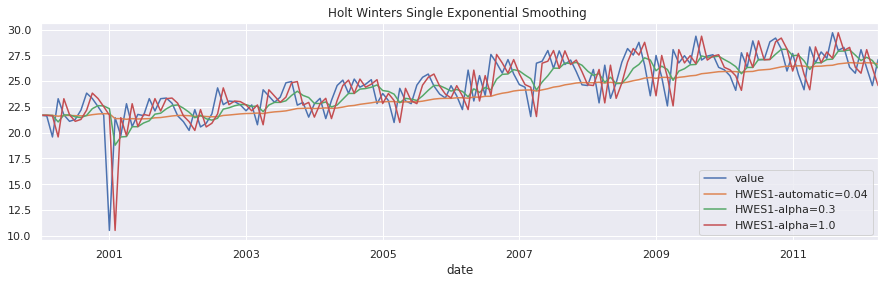

In [ ]:
# (1) Simple Exponential Smoothing with smoothing-level alpha
# source used: Section 8 (Holt-Winters section)
m = 12
alpha = 1/(2*m)

simpleHW = SimpleExpSmoothing(ts['value'])
simpleHWresults1 = simpleHW.fit(smoothing_level=alpha, optimized=False, use_brute=True)
ts['HWES1-automatic=0.04'] = simpleHWresults1.fittedvalues

simpleHWresults2 = simpleHW.fit(smoothing_level=0.3, optimized=False, use_brute=True)
ts['HWES1-alpha=0.3'] = simpleHWresults2.fittedvalues

simpleHWresults3 = simpleHW.fit(smoothing_level=1.0, optimized=False, use_brute=True)
ts['HWES1-alpha=1.0'] = simpleHWresults3.fittedvalues

fig, ax = plt.subplots(figsize=(15,4))
ts[['value','HWES1-automatic=0.04', 'HWES1-alpha=0.3', 'HWES1-alpha=1.0']].plot(title='Holt Winters Single Exponential Smoothing ', ax=ax)
print('Parameters for automatically selected smoothing level model:')
pprint(simpleHWresults1.params)

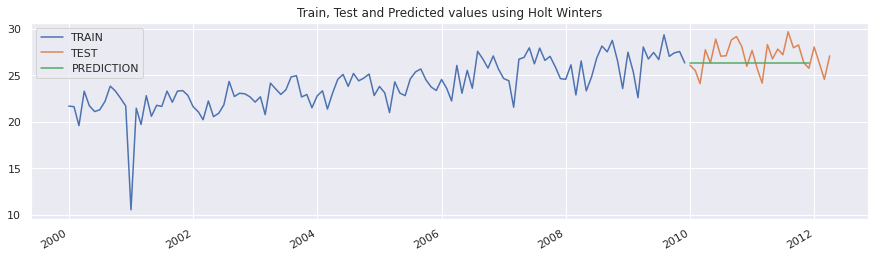

In [ ]:
# (2) to check prediction
train_ts = ts.iloc[:120]
test_ts=ts.iloc[120:]

simpleHW = SimpleExpSmoothing(train_ts['value'])
fitted_model = simpleHW.fit(smoothing_level=1.0, optimized=False, use_brute=True)
train_ts['HWES1-fitted on train'] = fitted_model.fittedvalues
test_predictions = fitted_model.forecast(steps=24)

fig = plt.figure(figsize=(15,4))
plt.plot(train_ts.index, train_ts.value, label='TRAIN')
# plt.plot(train_ts.index, train_ts['HWES1-fitted on train'], label='FITTED')
plt.plot(test_ts.index, test_ts.value, label='TEST')
# plt.plot(test_ts.index, test_predictions, label='PREDICTION')
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted values using Holt Winters')
plt.legend()
plt.show()

Model uses smoothing_level = 0.04, by increasing smoothing-level, we were able to make the line less smooth, and fitted values look very close to the original data. Now we will try HoltWinters model with trend and seasonal components.

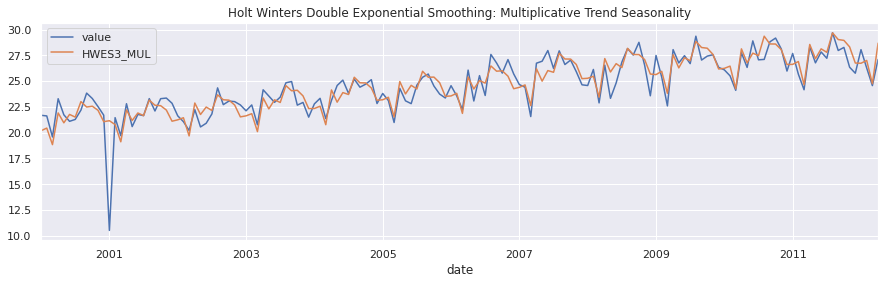

In [ ]:
# (3) Triple Exponential Smoothing with seasonality
tripleHW = ExponentialSmoothing(ts['value'], trend='mul', seasonal='mul', seasonal_periods=12)
tripleHWresults = tripleHW.fit(optimized=True, use_brute=True)
ts['HWES3_MUL'] = tripleHWresults.fittedvalues

fig, ax = plt.subplots(figsize=(15,4))
ts[['value','HWES3_MUL']].plot(title='Holt Winters Double Exponential Smoothing: Multiplicative Trend Seasonality', ax=ax)
plt.show()

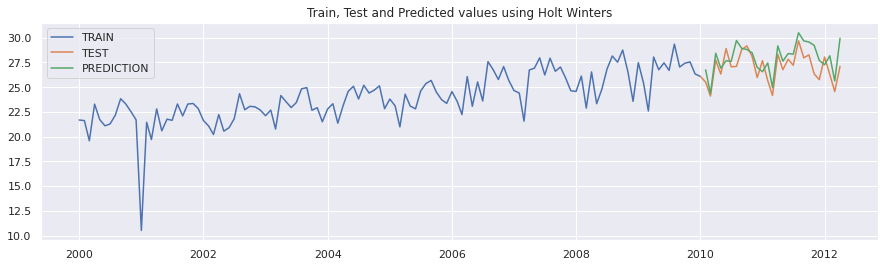

In [ ]:
# (4) to check prediction
train_ts = ts.iloc[:121]
test_ts=ts.iloc[120:]

fitted_model = ExponentialSmoothing(train_ts.value, trend='mul', seasonal='mul', seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(27)

fig = plt.figure(figsize=(15,4))
plt.plot(train_ts.index, train_ts.value, label='TRAIN')
plt.plot(test_ts.index, test_ts.value, label='TEST')
plt.plot(test_ts.index[1:], test_predictions, label='PREDICTION')
plt.title('Train, Test and Predicted values using Holt Winters')
plt.legend()
plt.show()

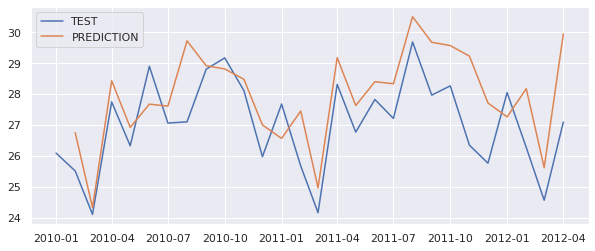

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
plt.plot(test_ts.index, test_ts['value'], label='TEST')
plt.plot(test_ts.index[1:], test_predictions, label='PREDICTION')
plt.legend()
plt.show()

It appears that we got a relatively good fit with much less manual work compared to the ARIMA model.

### Problem 3c (5 points)

Visually compare the raw data with the 3 models:  linear regression, time series and Holt-Winters on the same plot.

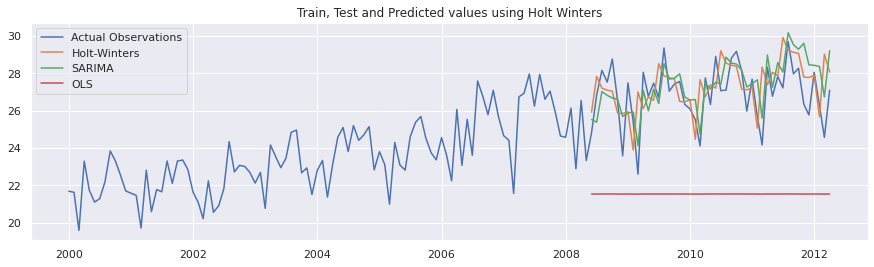

In [ ]:
# plot predictions
train_ts = ts.iloc[:101]
test_ts=ts.iloc[100:]

fig = plt.figure(figsize=(15,4))
plt.plot(ts.index, ts.value, label='Actual Observations')
plt.plot(test_ts.index, test_predictions, label='Holt-Winters')
plt.plot(test_ts.index, ts.SARIMApred7[100:], label='SARIMA')
plt.plot(test_ts.index, lr_predictions[-47:], label='OLS')
plt.title('linear regression, time series, Holt-Winters, and actual values')
plt.legend()
plt.show()

## Problem 4 Linear Classifier (30 points)

This is based on a real problem that gives you a different way of thinking about classifiers.  The goal is to write code that will form a "best" model separating the two classes using a single straight 2D line.  It's not a training-testing approach but could use a cross-validation methodology.  Each of the 3 datasets (dataset1.txt, dataset2.txt, and dataset3.txt) will have a different model.  You are welcome to use any method from classification, regression, optimization, deep learning, etc.  The "best" is in quotes since you can select your own reasonable definition. Some examples could be maximum margin, highest % classified, highest % classified with minimum distance of misclassified to line, etc.

#### Problem 4a (3 points)

State your metric of "best"

In [ ]:
# accuracy and missclassification rate

### Problem 4b (21 points)

Since this is an open-ended problem and we don't want this to be a time sink, we are offering a way out.  We will give you 7 points each for 3 reasonable approaches.  The final 6 will be for the extent that your solution works.  If you solve it in less than 3 approaches, kudos and we'll give you the full points so you don't need to try 3 approaches.  This is just an upper limit to save you spending hours on dozens of appraoches.

In [ ]:
# data set 1
data_set1 = pd.read_csv('dataset1.txt', sep="\t")
print('Data set dimentions:', data_set1.shape)
print('Missing values: ',data_set1.isnull().values.sum()) # check missing values
data_set1.head()

Data set dimentions: (38, 3)
Missing values:  0


,x,y,label
0,23.782188,136.434724,1
1,18.065304,114.861048,1
2,29.350252,210.363544,1
3,18.967352,128.284473,1
4,29.153578,215.393469,1


In [ ]:
print(' Count of 1 and 0 in "output":\n',data_set1.label.value_counts())
# balanced data

 Count of 1 and 0 in "output":
 1    19
0    19
Name: label, dtype: int64


In [ ]:
features = ['x', 'y']
data_x = data_set1[['x', 'y']]
data_y = data_set1['label']

# scale data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(data_x), columns=features)

print('The size of the design matrix is: ', X_scaled.shape)
X_scaled.head()

The size of the design matrix is:  (38, 2)


,x,y
0,-0.008797,0.633874
1,-0.501684,0.290549
2,0.471261,1.810382
3,-0.423913,0.504171
4,0.454304,1.890429


In [ ]:
# Build baseline-Logistic Rgression
logit1 = LogisticRegression(C=10000,fit_intercept=True).fit(X_scaled, data_y)

print('Logistic Regression Estimated Coef:',logit1.intercept_,logit.coef_)
print('Overall accuracy rate:',logit1.score(X_scaled,data_y))
print('Overall misclassification rate in train:',1-logit1.score(X_scaled,data_y))

Logistic Regression Estimated Coef: [1.72924948] [[-1.49494915  0.40055455]]
Overall accuracy rate: 1.0
Overall misclassification rate in train: 0.0


In [ ]:
# tuning Logit to iterate over c-values
cs_vals = [0.01, 0.1, 1, 10, 100, 1000]
score_acc_list_train = list()

for c in cs_vals:
    logit_2 =  LogisticRegression(C=c, max_iter=2000, penalty='l2')
    score_acc_list_train.append(np.mean(cross_val_score(logit_2, X_scaled, data_y, cv=5)))

#  store results in df
score_df = pd.DataFrame({r'C Value': cs_vals, r'CV Score': score_acc_list_train})
print('The best model is the model with C={} '.
      format(score_df.iloc[score_df['CV Score'].idxmax()]['C Value']))
score_df

The best model is the model with C=0.1 


,C Value,CV Score
0,0.01,0.914286
1,0.10,1.000000
2,1.00,1.000000
3,10.00,1.000000
4,100.00,1.000000
5,1000.00,1.000000


In [ ]:
# fit model with adjusted c penalty
logit_3 =  LogisticRegression(C=0.1, max_iter=2000, penalty='l2')
logit_3.fit(X_scaled, data_y)

print('Logistic Regression Estimated Coef:',logit_3.intercept_,logit.coef_)
print('Overall accuracy rate:',logit_3.score(X_scaled,data_y))
print('Overall misclassification rate:',1-logit_3.score(X_scaled,data_y))

Logistic Regression Estimated Coef: [0.00869806] [[-1.49494915  0.40055455]]
Overall accuracy rate: 1.0
Overall misclassification rate: 0.0


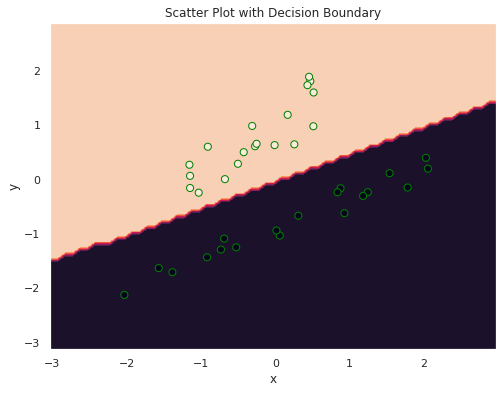

In [ ]:
# code adapted from https://favtutor.com/blogs/decision-boundary-logistic-regression
# plotting the decision boundary

x_min, x_max = X_scaled.iloc[:, 0].min() - 1, X_scaled.iloc[:, 0].max() + 1
y_min, y_max = X_scaled.iloc[:, 1].min() - 1, X_scaled.iloc[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z0 = logit_3.predict(np.c_[xx.ravel(), yy.ravel()])
Z0 = Z0.reshape(xx.shape)

plt.figure(figsize = (8, 6))
plt.contourf(xx, yy, Z0)
plt.scatter(X_scaled.iloc[:, 0], X_scaled.iloc[:, 1], c = data_y, s = 50, edgecolor = 'green')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot with Decision Boundary')
plt.show()

In [ ]:
# data set 2
data_set2 = pd.read_csv('dataset2.txt', sep="\t")
print('Data set dimentions:', data_set2.shape)
print('Missing values: ',data_set2.isnull().values.sum()) # check missing values
data_set2.head()

Data set dimentions: (32, 3)
Missing values:  0


,x,y,label
0,15.41,348.4141,0
1,7.06,314.1996,0
2,5.94,314.6405,0
3,3.34,226.8833,0
4,3.99,394.7450,0


In [ ]:
print(' Count of 1 and 0 in "output":\n',data_set2.label.value_counts())
# imbalanced data

 Count of 1 and 0 in "output":
 1    60
0    40
Name: label, dtype: int64


In [ ]:
features = ['x', 'y']
data_x2 = data_set2[['x', 'y']]
data_y2 = data_set2['label']

# scale data
scaler = StandardScaler()
X_scaled2 = pd.DataFrame(scaler.fit_transform(data_x2), columns=features)

print('The size of the design matrix is: ', X_scaled2.shape)
X_scaled2.head()

The size of the design matrix is:  (32, 2)


,x,y
0,2.044394,0.072456
1,0.227155,-0.388502
2,-0.016595,-0.382562
3,-0.582442,-1.564878
4,-0.440980,0.696652


In [ ]:
# fit the same model on the 2nd data set
logit_4 =  LogisticRegression(C=0.1, max_iter=2000, penalty='l2')
logit_4.fit(X_scaled2, data_y2)

print('Logistic Regression Estimated Coef:',logit_4.intercept_,logit.coef_)
print('Overall accuracy rate:',logit_4.score(X_scaled2,data_y2))
print('Overall misclassification rate:',1-logit_4.score(X_scaled2,data_y2))

Logistic Regression Estimated Coef: [0.12786153] [[-1.49494915  0.40055455]]
Overall accuracy rate: 0.71875
Overall misclassification rate: 0.28125


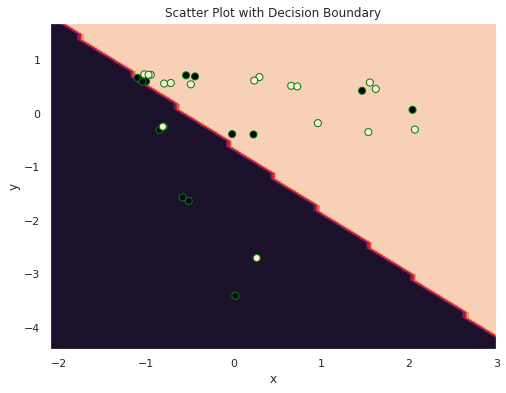

In [ ]:
# plo decision boundaries for the 2nd data set
x_min, x_max = X_scaled2.iloc[:, 0].min() - 1, X_scaled2.iloc[:, 0].max() + 1
y_min, y_max = X_scaled2.iloc[:, 1].min() - 1, X_scaled2.iloc[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z1 = logit_4.predict(np.c_[xx.ravel(), yy.ravel()])
Z1= Z1.reshape(xx.shape)

plt.figure(figsize = (8, 6))
plt.contourf(xx, yy, Z1)
plt.scatter(X_scaled2.iloc[:, 0], X_scaled2.iloc[:, 1], c = data_y2, s = 50, edgecolor = 'green')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot with Decision Boundary')
plt.show()

About 72% accuracy and not the best split between classes. As this is imbalnced data set, we might want to adjust weights and penalty terms.

In [ ]:
# data set 3
data_set3 = pd.read_csv('dataset3.txt', sep="\t")
print('Data set dimentions:', data_set3.shape)
print('Missing values: ',data_set3.isnull().values.sum()) # check missing values
data_set3.head()

Data set dimentions: (100, 3)
Missing values:  0


,x,y,label
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,45.083277,56.316372,0
4,95.861555,38.225278,0


In [ ]:
print(' Count of 1 and 0 in "output":\n',data_set3.label.value_counts())
# imbalanced data

 Count of 1 and 0 in "output":
 1    60
0    40
Name: label, dtype: int64


In [ ]:
features = ['x', 'y']
data_x3 = data_set3[['x', 'y']]
data_y3 = data_set3['label']

# scale data
scaler = StandardScaler()
X_scaled3 = pd.DataFrame(scaler.fit_transform(data_x3), columns=features)

print('The size of the design matrix is: ', X_scaled3.shape)
X_scaled3.head()

The size of the design matrix is:  (100, 2)


,x,y
0,-1.602248,0.638341
1,-1.826256,-1.207541
2,-1.539040,0.361294
3,-1.061997,-0.535739
4,1.560755,-1.514185


In [ ]:
# fit the same model to the 3rd data set
logit_5 =  LogisticRegression(C=0.1, max_iter=2000, penalty='l2')
logit_5.fit(X_scaled3, data_y3)

print('Logistic Regression Estimated Coef:',logit_5.intercept_,logit.coef_)
print('Overall accuracy rate:',logit_5.score(X_scaled3,data_y3))
print('Overall misclassification rate:',1-logit_5.score(X_scaled3,data_y3))

Logistic Regression Estimated Coef: [0.54932607] [[-1.49494915  0.40055455]]
Overall accuracy rate: 0.92
Overall misclassification rate: 0.07999999999999996


We have a better accuracy and missclassification rates for the 3rd data set.

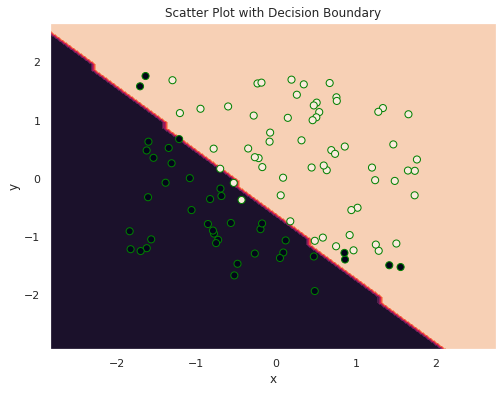

In [ ]:
# plo decision boundaries for the 3rd data set
x_min, x_max = X_scaled3.iloc[:, 0].min() - 1, X_scaled3.iloc[:, 0].max() + 1
y_min, y_max = X_scaled3.iloc[:, 1].min() - 1, X_scaled3.iloc[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z2 = logit_5.predict(np.c_[xx.ravel(), yy.ravel()])
Z2 = Z2.reshape(xx.shape)

plt.figure(figsize = (8, 6))
plt.contourf(xx, yy, Z2)
plt.scatter(X_scaled3.iloc[:, 0], X_scaled3.iloc[:, 1], c = data_y3, s = 50, edgecolor = 'green')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot with Decision Boundary')
plt.show()

Classifier did a relatively good job here.

### Problem 4c (6 points)

Plot the best-fit line overlaying the plots.  Describe how well it worked.

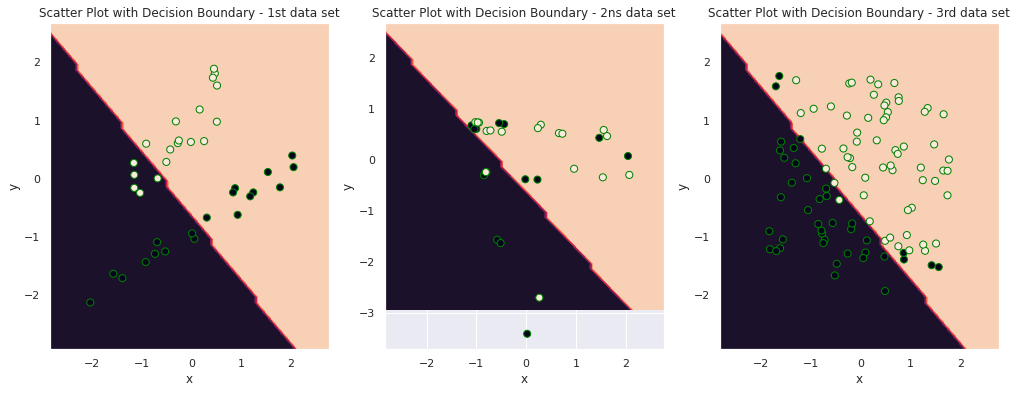

In [ ]:
# satistics plots
fig, axes = plt.subplots(1,3,figsize=(17,6))
axes[0].contourf(xx, yy, Z)
axes[0].scatter(X_scaled.iloc[:, 0], X_scaled.iloc[:, 1], c = data_y, s = 50, edgecolor = 'green')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Scatter Plot with Decision Boundary - 1st data set')

axes[1].contourf(xx, yy, Z)
axes[1].scatter(X_scaled2.iloc[:, 0], X_scaled2.iloc[:, 1], c = data_y2, s = 50, edgecolor = 'green')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('Scatter Plot with Decision Boundary - 2ns data set')

axes[2].contourf(xx, yy, Z)
axes[2].scatter(X_scaled3.iloc[:, 0], X_scaled3.iloc[:, 1], c = data_y3, s = 50, edgecolor = 'green')
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
axes[2].set_title('Scatter Plot with Decision Boundary - 3rd data set')
plt.show()


## Problem 5a Hours (2 points)
How many hours did this homework take you?  The answer to this question will not affect your grade.

In [ ]:
# ~55 hrs

##### Problem 5b Pdf file (3 points)

Save this notebook as LastnameFirstnameHW4.ipynb such as JacksonMichael.ipynb. You don't need to include any datasets.  Create a pdf of this notebook named similarly. Submit both the python notebook and the pdf version to the Canvas dropbox. We require both versions.

In [ ]:
# EngelhardtMarinaHW4.ipynb